In [28]:
import numpy as np
import pandas as pd
import datetime
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pytz

# SB Updates: inconsistencies with empyrical and pyfolio current version
import empyrical

In [29]:
tolerance = 0.
look_back = 12

# Vol scaling
vol_flag = 1                  # Set flag to 1 for vol targeting
if vol_flag == 1:
    target_vol = 0.4
else:
    target_vol = 'no target vol'

# 1a. Individual Futures Performance

In [30]:
# SB Updates: use pandas library instead of csv library
res = pd.read_csv("./data/futures.csv")
# res = local_csv("futures_incl_2016.csv") # Uncomment this line to include 2016
res['Date'] = pd.to_datetime(res['Date'], format='%Y-%m-%d')
res.set_index('Date', inplace=True)

In [22]:
std_index = res.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', \
                                    'Skew', 'Kurt', 'Sharpe Ratio'])

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [31]:
for oo in res.columns:
    returns = res[oo]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [oo, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    
    # SB Updates: `ix` is deprecated to we use `iloc` instead
    ret_m_index.iloc[0][oo] = 1

    mth_index = pd.concat([mth_index, ret_m_index[oo]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = oo + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[oo].pct_change().mean()*252
    tmp_std = ret_index[oo].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[oo].pct_change().skew()
    tmp_kurt = ret_index[oo].pct_change().kurt()
    sr = tmp_mean / tmp_std

    dict = {'Asset': oo,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[oo] = pd.Series(dict)    

In [27]:
summary_stats = summary_stats.transpose()
futures_list = pd.read_csv("./data/futures_list.csv")
# futures_list
# summary_stats
all = summary_stats.reset_index().merge(futures_list)
all.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del all['Asset'], all['index']

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

### Individual Futures Contracts Performance
These are annualized performance.

In [32]:
all.set_index(['ASSET_CLASS', 'FUTURES']).style.set_properties(**{'text-align': 'right'})

# SB Updates: saved to output file
# all.to_csv('AssetClass_Futures_Sorted.csv')

In [33]:
# 1b. Trading Strategy - TSMOM with Volatility Scaling (1984 - 2009)


In [34]:
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [10]:
for oo in mth_index:
    df = pd.concat([mth_index[oo], mth_index_vol[oo+"_Vol"]], axis=1)
    df['returns'] = df[oo].pct_change(look_back)
    
    df['pnl'] = 0.
    df['leverage'] = 0.
    try:
        for k, v in enumerate(df['returns']):
            if k <= look_back:
                # skip the first 12 observations
                continue
            if df['returns'].iloc[k-1] < tolerance:
                # negative returns, sell and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1)                   
                    df['leverage'].iloc[k] = 1.
            elif df['returns'].iloc[k-1] > tolerance:
                # positive returns, buy and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) 
                    df['leverage'].iloc[k] = 1.
    except: pass    
    # convert to cummulative index
    pnl = pd.concat([pnl, df['pnl']], axis=1)
    leverage = pd.concat([leverage, df['leverage']], axis=1)
    
    ret_index = (1 + df['pnl'][13:]).cumprod()
    ret_index[0] = 1
    strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1) 

In [12]:
# pnl
pnl.columns = res.columns
leverage.columns = leverage.columns
strategy_cumm_rtns.columns = res.columns
df = pnl
df['port_avg'] = df.mean(skipna = 1, axis=1)
Strategy = df['port_avg'].copy()
Strategy.name = "TSMOM with Vol"
dataport_index = (1 + df['port_avg']).cumprod()

# SB Updates: saved to output file
# pnl.to_csv('Strategy_TSMOM_With_Vol.csv')

In [13]:
# SB Updates: `pf.empyrical` to `empyrical` everywhere
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(df['port_avg'], period='monthly'))
print ("Annualized Mean Returns = ", empyrical.annual_return(df['port_avg'], period='monthly'))

print ("Annualized Standard Deviations = ", empyrical.annual_volatility(df['port_avg'], period='monthly'))

Annualized Sharpe Ratio =  1.5594286210223922
Annualized Mean Returns =  0.15820525315443468
Annualized Standard Deviations =  0.0977748556596916


In [14]:
print ("Max Drawdown = ", empyrical.max_drawdown(df['port_avg']))
print ("Calmar ratio = ", empyrical.calmar_ratio(df['port_avg'], period='monthly'))

Max Drawdown =  -0.1407262029068766
Calmar ratio =  1.12420608164298


Start date,1984-01-31
End date,2009-12-31
Total months,14
,Backtest
Annual return,2085.225%
Cumulative returns,4454.323%
Annual volatility,44.806%
Sharpe ratio,7.15
Calmar ratio,148.18
Stability,0.96
Max drawdown,-14.073%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.07,2003-05-30,2003-08-29,2003-12-31,154
1,13.54,2009-02-27,2009-07-31,NaT,NaN
2,9.17,2008-06-30,2008-09-30,2008-10-31,90
3,9.13,1995-03-31,1995-08-31,1996-04-30,283
4,8.03,1993-12-31,1994-03-31,1994-10-31,217


C:\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and w

Stress Events,mean,min,max
Dotcom,2.44%,-2.87%,5.45%
Lehman,-2.47%,-3.74%,-1.21%
9/11,9.52%,9.52%,9.52%
US Housing,5.28%,5.28%,5.28%
Aug07,-1.90%,-1.90%,-1.90%
Mar08,-1.04%,-1.04%,-1.04%
Sept08,-1.21%,-1.21%,-1.21%
2009Q1,2.17%,1.28%,3.07%
2009Q2,-4.35%,-7.21%,-1.88%
Low Volatility Bull Market,2.04%,-5.54%,7.36%


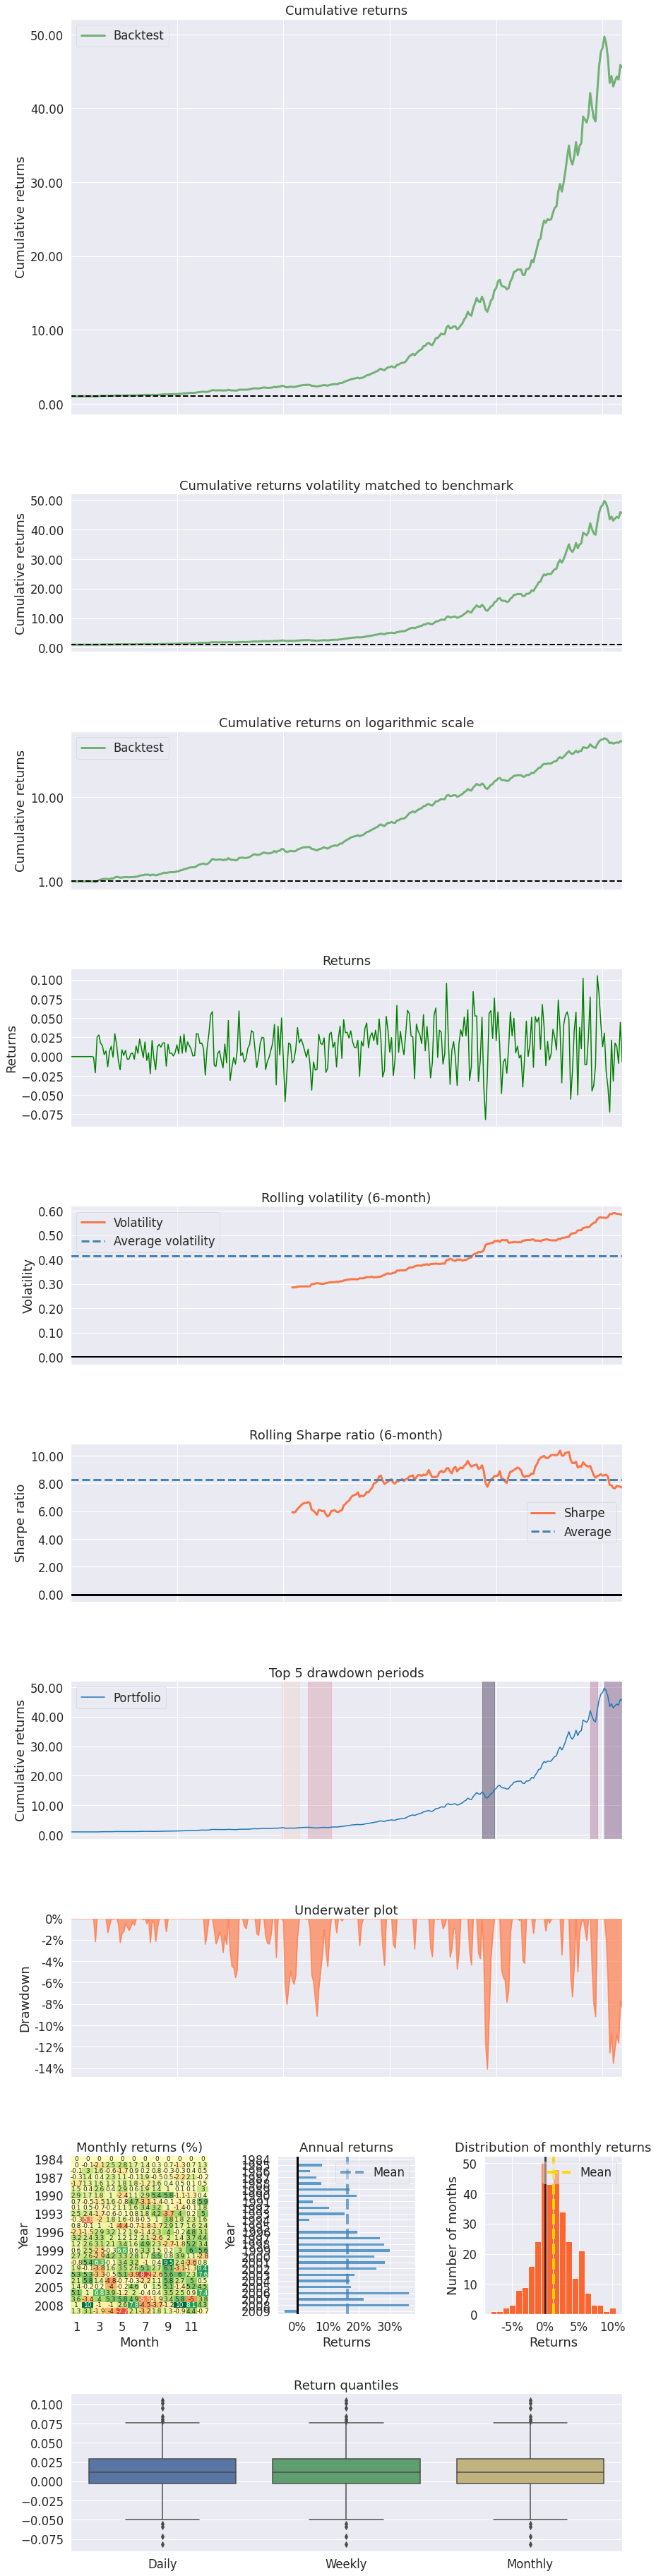

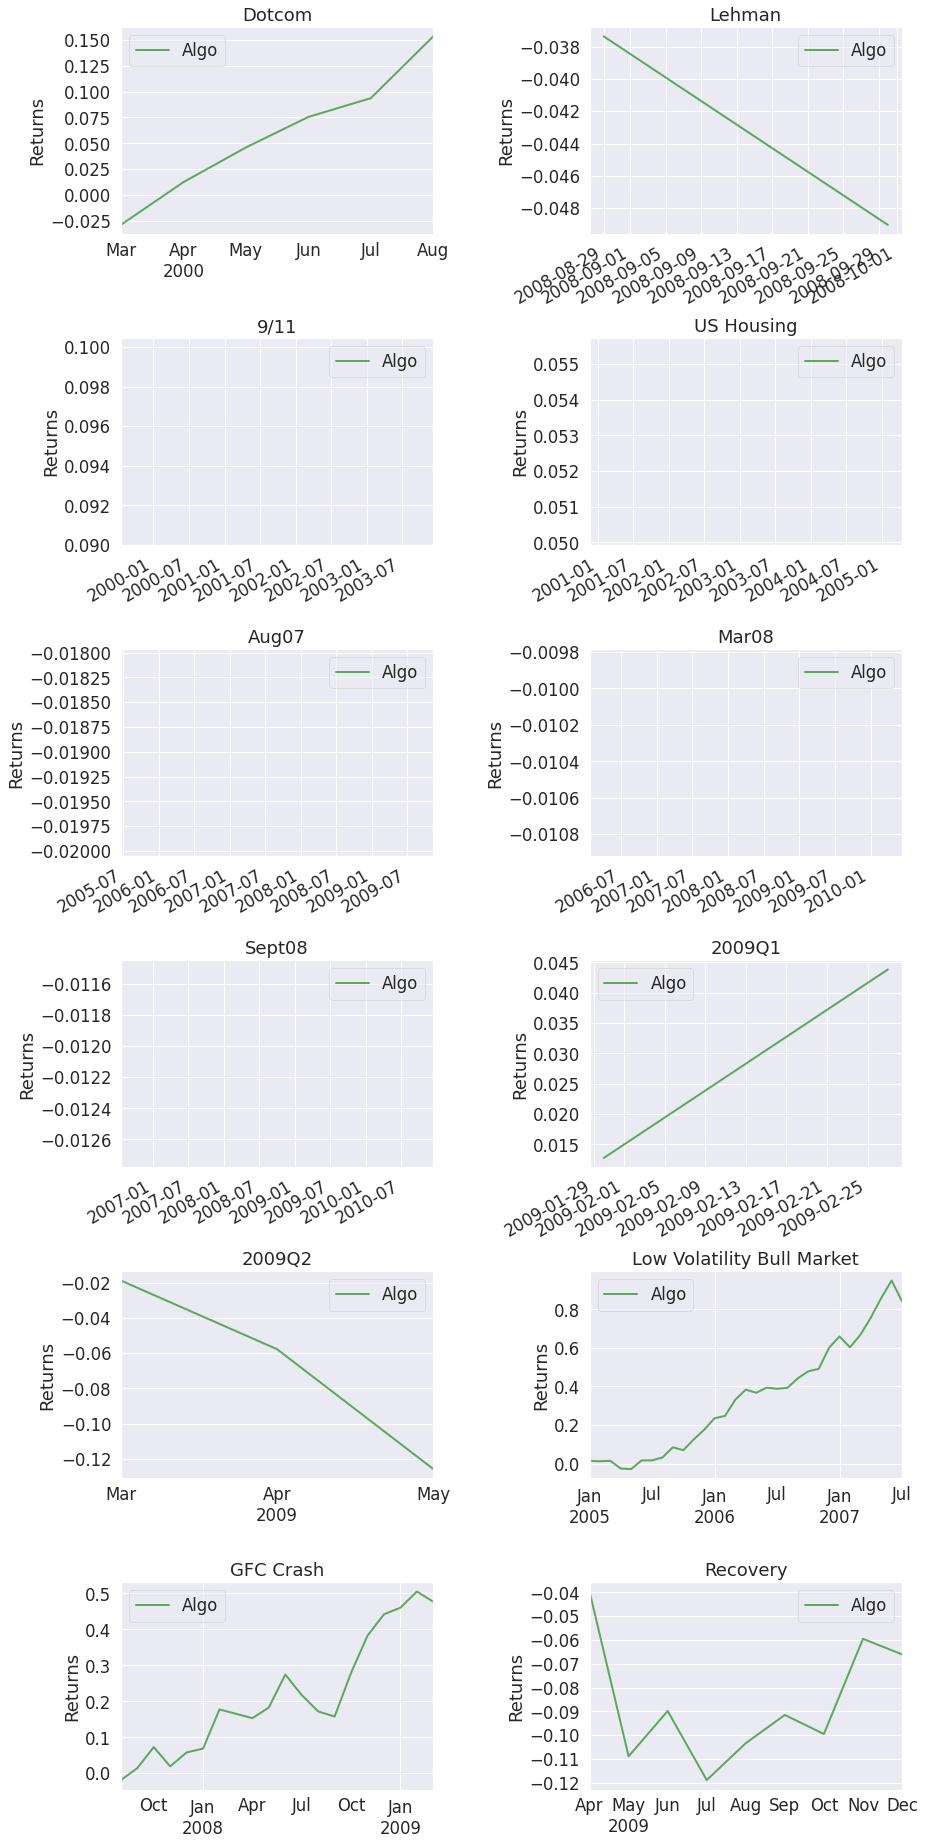

In [15]:
eastern = pytz.timezone('US/Eastern')
# df['port_avg'].index

# SB Updates: added to_datetime conversion
df['port_avg'].index = df['port_avg'].index.tz_localize(eastern)

pf.create_full_tear_sheet(df['port_avg'])
# df['port_avg'].index
# df['port_avg'].index = df['port_avg'].index.tz_convert(eastern)
# pf.create_full_tear_sheet(df['port_avg'])

*****

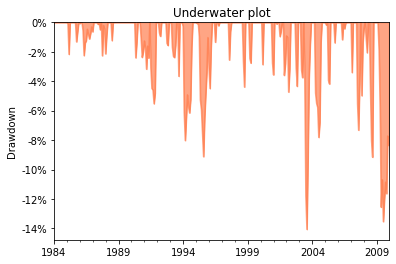

In [17]:
pf.plot_drawdown_underwater(df['port_avg']);

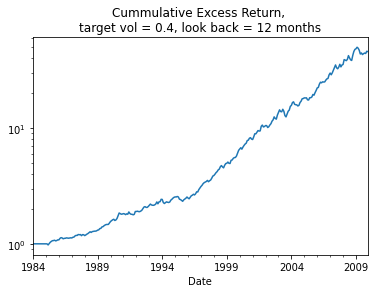

In [18]:
ax = (1 + df['port_avg']).cumprod().plot(logy=True)
ax.set_title("Cummulative Excess Return, " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months")

In [20]:
tmp = df['port_avg'].reset_index()
tmp['Date'] = pd.to_datetime(tmp['Date'], format='%Y-%m-%d')
tmp = tmp.set_index('Date')
tmp['month'] = tmp.index.month
tmp['year'] = tmp.index.year
tmp = np.round(tmp, 3)
res = tmp.pivot('year', 'month', 'port_avg')
res['total'] = np.sum(res, axis=1)

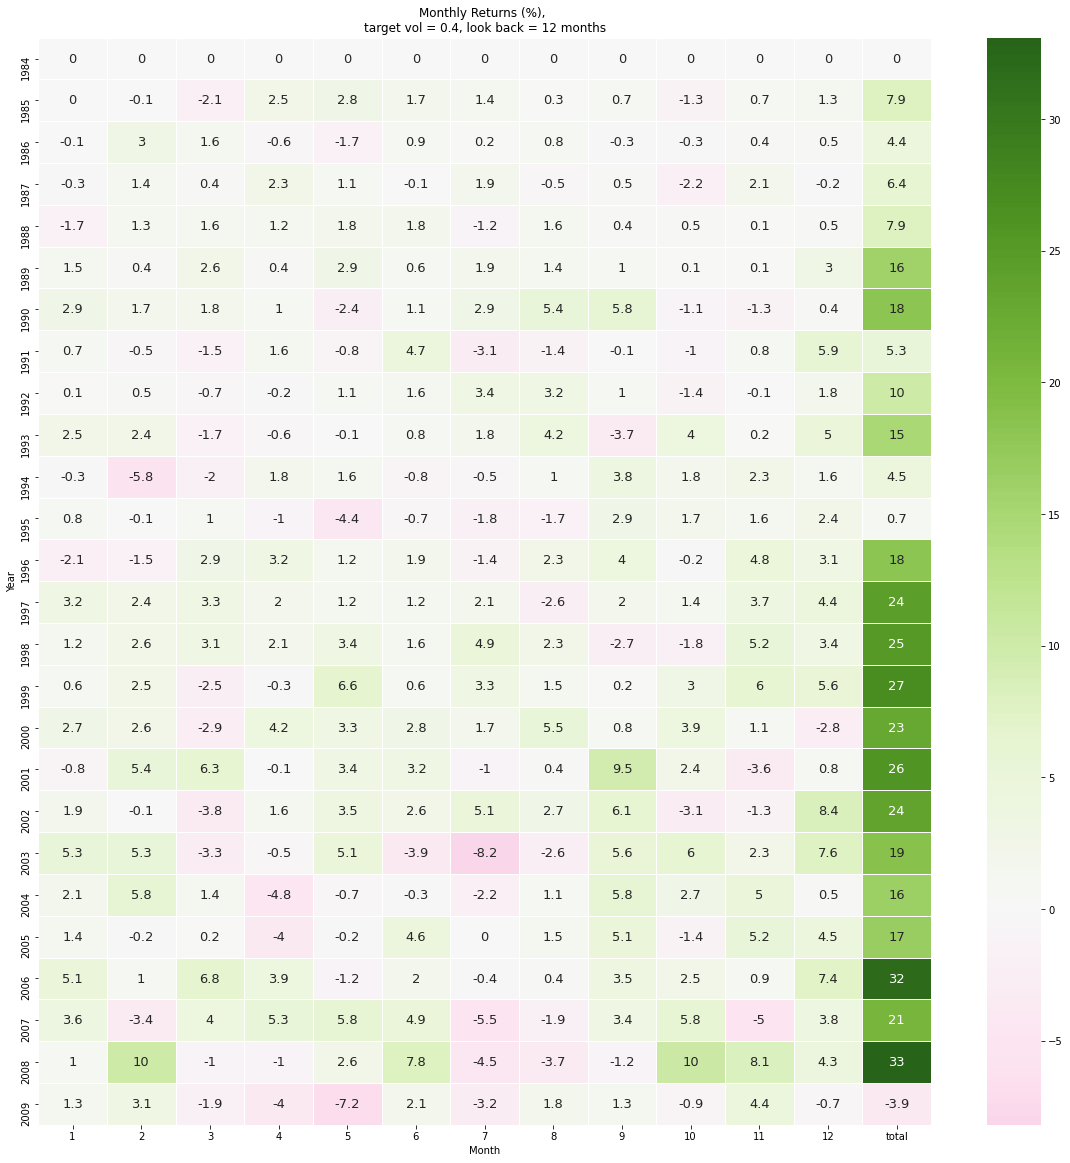

In [21]:
fig, ax = plt.subplots(figsize=(20,20));
sns.heatmap(res.fillna(0) * 100,
            annot=True,
            annot_kws={
                "size": 13},
            alpha=1.0,
            center=0.0,
            cbar=True,
            cmap=matplotlib.cm.PiYG,
            linewidths=.5,
            ax = ax); 
ax.set_ylabel('Year');
ax.set_xlabel('Month');
ax.set_title("Monthly Returns (%), " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months");
plt.show()